# Quantum VQA for Swaption Price Prediction

## データ処理フロー

このノートブックでは、スワップション価格データを量子機械学習モデルで予測します。以下にデータ処理の全体フローを示します。

![Untitled diagram-2025-11-05-160232.png](<attachment:Untitled diagram-2025-11-05-160232.png>)

### データ処理の主要ステップ

1. **データ読み込み** (`load_and_preprocess`)
   - Excelファイルから生データ読み込み
   - 日付インデックス設定
   - 欠損値補完

2. **メタ情報抽出** (`extract_tenor_maturity`)
   - 列名から Tenor（スワップ期間）と Maturity（オプション満期）を抽出

3. **時系列ウィンドウ化** (`create_windowed_data`)
   - 過去N日分の価格データをウィンドウとして作成
   - 次の日の価格を予測ターゲットに設定

4. **特徴量統合** (`get_features_and_targets`)
   - **構造的特徴量**: Tenor/Maturity値そのもの
   - **横列関係性特徴量**: 異なる Tenor/Maturity 間の関係性
     - Tenorスプレッド: 同じMaturityで異なるTenor間の価格差
     - Maturity傾き: 同じTenorで異なるMaturity間の価格変化率
     - グループ統計量: 各グループ内の平均・標準偏差

5. **データ品質保証**
   - infinity/NaN値のチェックとクリーンアップ
   - 全特徴量の結合と検証
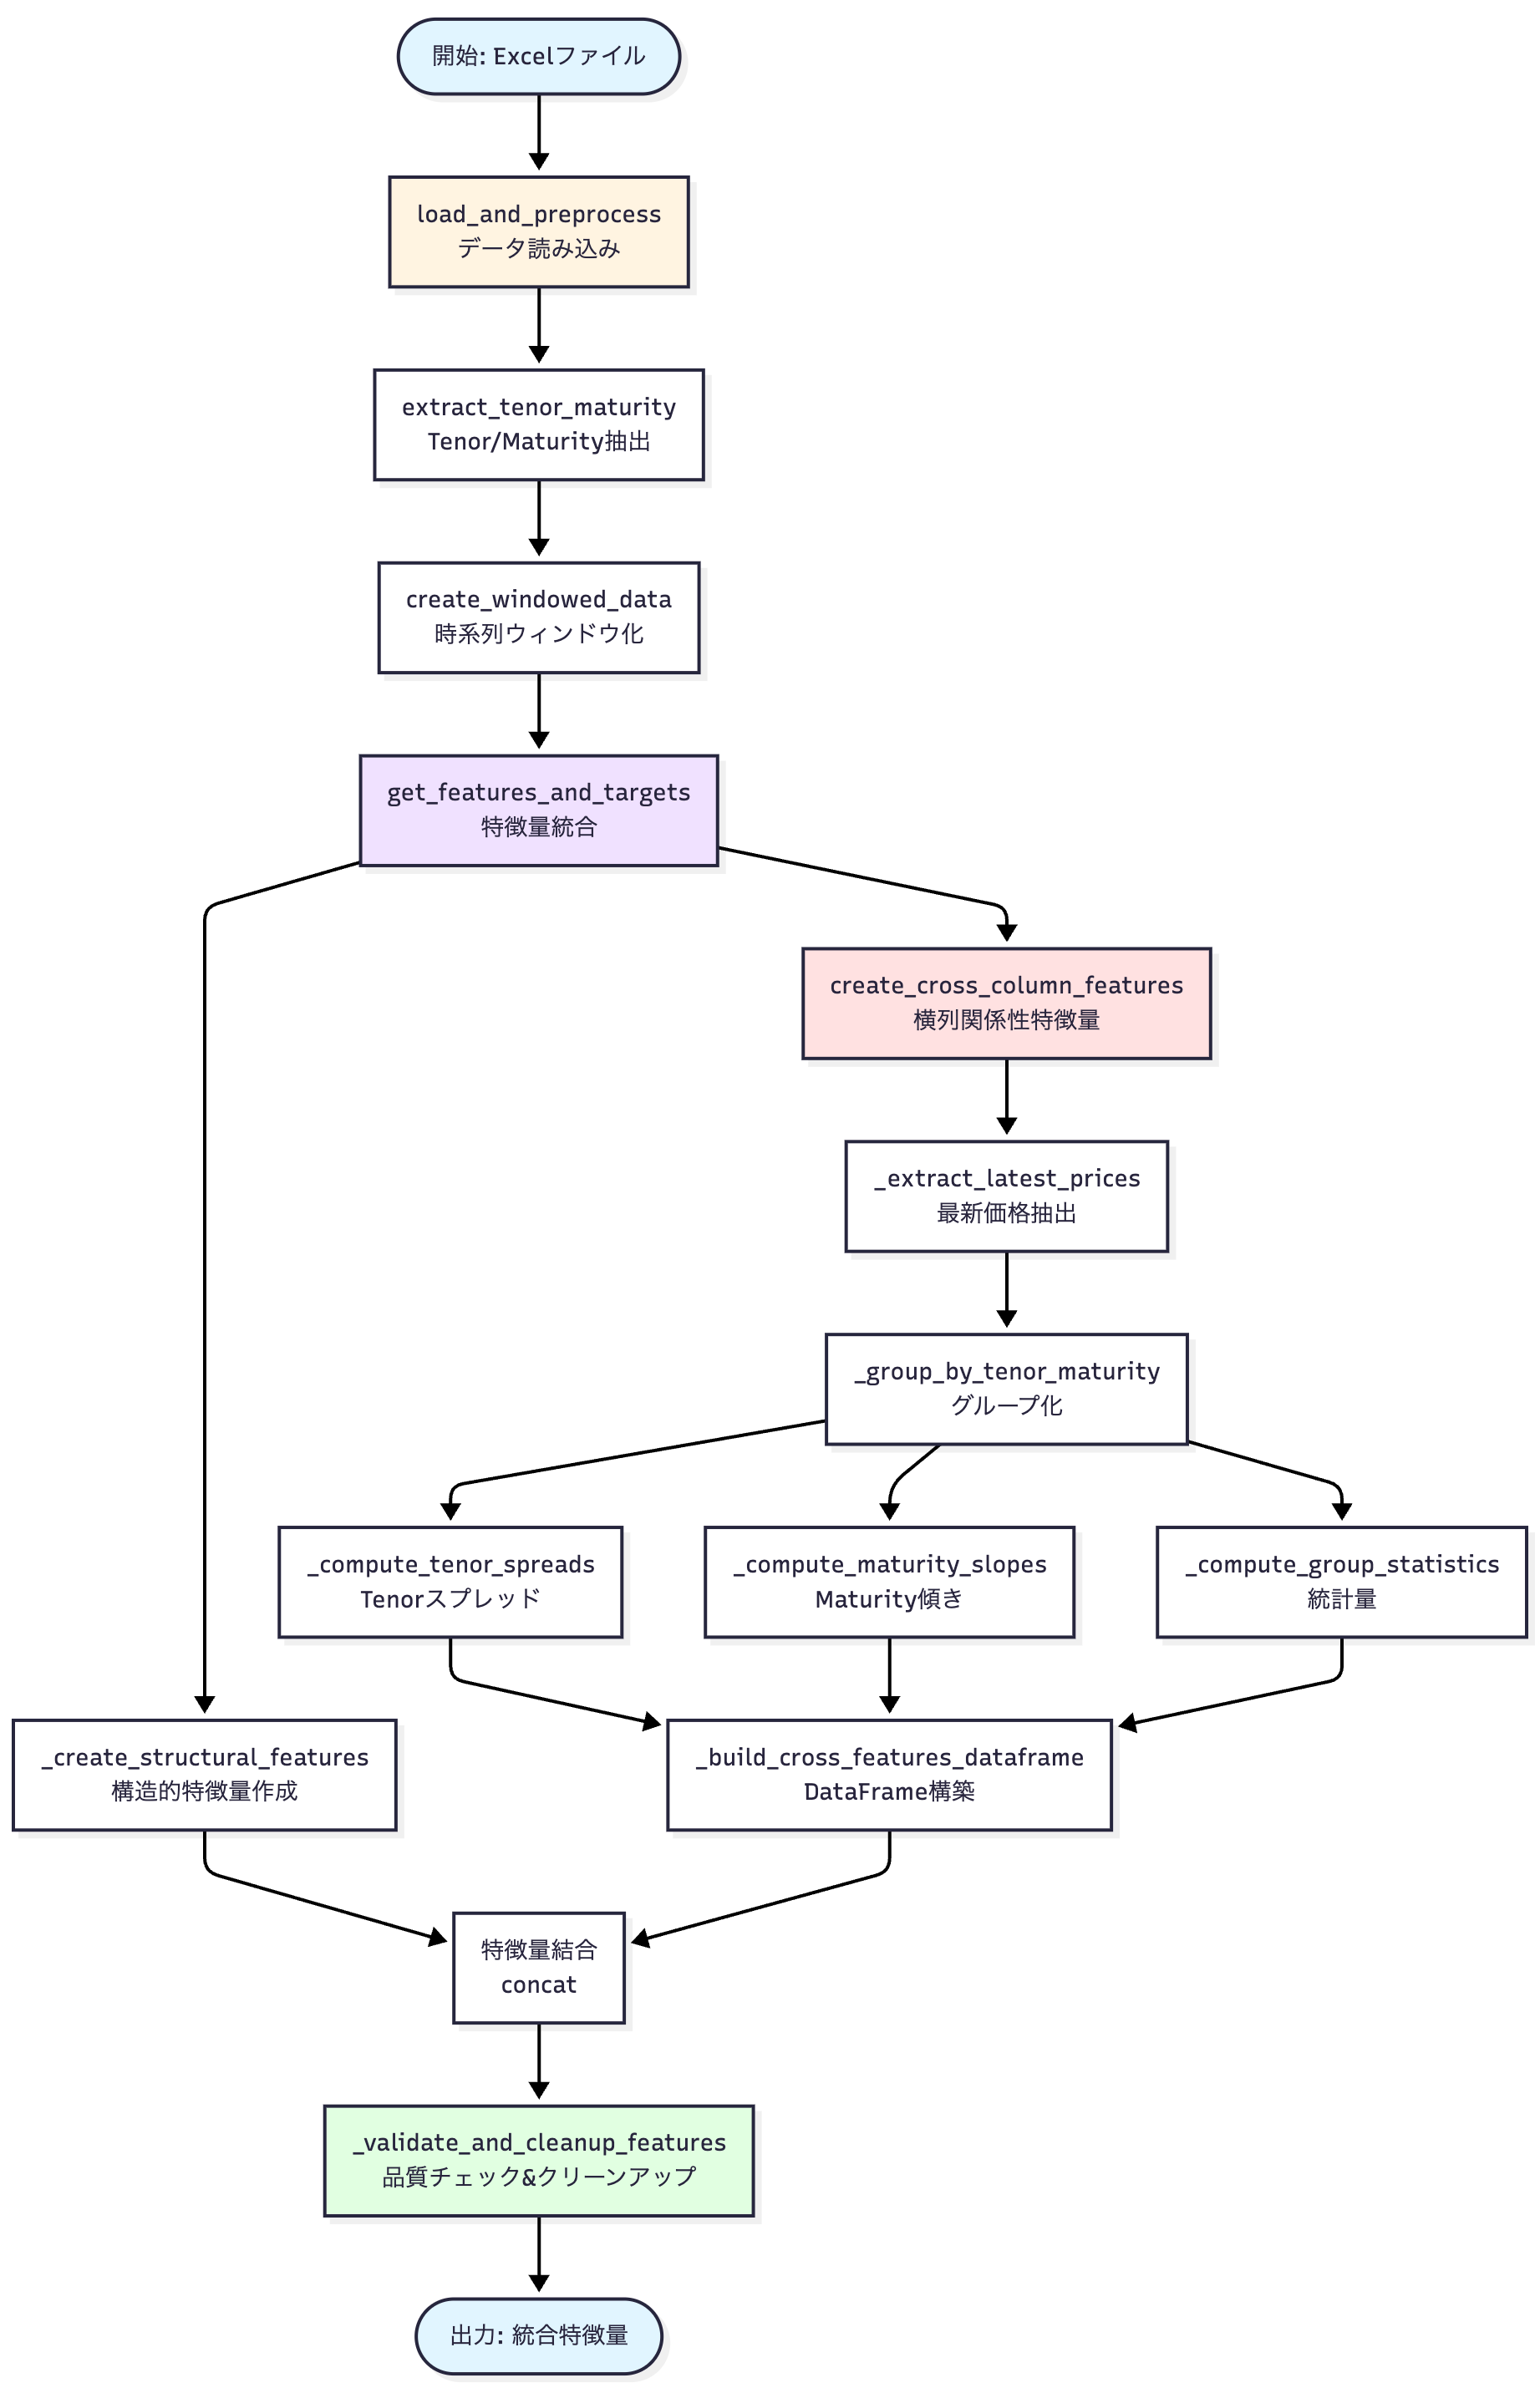

In [38]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_algorithms.optimizers import SPSA
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import re
from typing import Tuple, List, Optional, Dict


# ==================== Constants ====================
# データ処理関連
ZERO_DIVISION_THRESHOLD = 1e-6
LATEST_TIME_STEP = '_t-1'  # ウィンドウ内の最新時刻

# 量子回路関連
DEFAULT_N_QUBITS = 3
DEFAULT_N_LAYERS = 2
DEFAULT_SHOTS = 1000

# スケーリング関連
ANGLE_RANGE_LOW = 0.0
ANGLE_RANGE_HIGH = 2 * math.pi
TARGET_SCALE_MIN = -1
TARGET_SCALE_MAX = 1

# 最適化関連
DEFAULT_MAX_ITER = 100
LARGE_LOSS_VALUE = 1e6

# 可視化関連
PLOT_FIGSIZE_WIDE = (12, 5)
PLOT_FIGSIZE_STANDARD = (6, 3)
PLOT_DPI = 100


# ==================== Data Processing Class ====================
class DataProcessor:
    """スワップションデータの読み込み・前処理・特徴量生成を行うクラス"""
    
    def __init__(self, file_path: str, window: int = 7):
        self.file_path = file_path
        self.window = window
        
        self.df_numeric = None
        self.target_columns = None
        self.tenor_maturity = None
        self.date_index = None
        
    def load_and_preprocess(self) -> None:
        """Excelファイルを読み込み、日付インデックス設定と欠損値補完を実行"""
        df = pd.read_excel(self.file_path)
        print('Original shape:', df.shape)
        
        # 日付インデックス設定
        date_col = df.columns[-1]
        df[date_col] = pd.to_datetime(df[date_col], format='%m/%d/%Y')
        df = df.set_index(date_col).sort_index()
        
        # 数値列のみ抽出・欠損値補完
        self.df_numeric = df.select_dtypes(include=[np.number]).ffill().bfill().fillna(0.0)
        self.target_columns = self.df_numeric.columns.tolist()
        self.date_index = self.df_numeric.index
        
    def extract_tenor_maturity(self) -> np.ndarray:
        """列名からTenor/Maturityを抽出"""
        def _extract(col_name: str) -> Tuple[float, float]:
            tenor_match = re.search(r'Tenor\s*:\s*([\d.]+)', col_name)
            maturity_match = re.search(r'Maturity\s*:\s*([\d.]+)', col_name)
            tenor = float(tenor_match.group(1))
            maturity = float(maturity_match.group(1))
            return tenor, maturity
        
        tenor_maturity_list = [_extract(col) for col in self.target_columns]
        self.tenor_maturity = np.array(tenor_maturity_list)
        
        return self.tenor_maturity
    
    def create_windowed_data(self) -> Tuple[pd.DataFrame, pd.Series, pd.DatetimeIndex, pd.DatetimeIndex]:
        """ウィンドウ化されたデータをDataFrameとして生成（日付インデックス付き）"""
        n_samples = len(self.df_numeric) - self.window

        
        # ウィンドウ化されたデータを格納するリスト
        X_data_list = []
        y_data_list = []
        X_date_indices = []
        y_date_indices = []
        
        for i in range(n_samples):
            # 価格データ: ウィンドウ内の全データをフラット化
            X_window = self.df_numeric.iloc[i:i+self.window].values.flatten()  # (window*features,)
            X_data_list.append(X_window)
            
            # y: 予測対象日のデータ
            y_window = self.df_numeric.iloc[i+self.window].values  # (features,)
            y_data_list.append(y_window)
            
            # 日付インデックス
            X_date_indices.append(self.date_index[i+self.window-1])  # ウィンドウの最後の日付をXの代表日とする
            y_date_indices.append(self.date_index[i+self.window])
        
        # DataFrameとして構築
        X_columns = [f'{col}_t-{self.window-j}' for j in range(self.window) for col in self.target_columns]
        X_df = pd.DataFrame(X_data_list, columns=X_columns, index=X_date_indices)
        y_series = pd.DataFrame(y_data_list, columns=self.target_columns, index=y_date_indices)
        
        print('X date index:', X_df.index.min(), 'to', X_df.index.max())
        print('y date index:', y_series.index.min(), 'to', y_series.index.max())
        
        return X_df, y_series, X_df.index, y_series.index
    
    def create_cross_column_features(self, prices_df: pd.DataFrame) -> pd.DataFrame:
        """横の列（異なるTenor/Maturity）間の関係性を表す特徴量を生成
        
        Args:
            prices_df: ウィンドウ化された価格データ（時刻情報付き列名）
            
        Returns:
            クロスカラム特徴量のDataFrame
        """
        # ステップ1: 最新時点の価格データを抽出
        current_df = self._extract_latest_prices(prices_df)
        if current_df.empty:
            return pd.DataFrame(index=prices_df.index)
        
        # ステップ2: Tenor/Maturityでグループ化
        tenor_groups, maturity_groups = self._group_by_tenor_maturity(current_df)
        
        # ステップ3: 各種特徴量を計算
        cross_features = []
        cross_features.extend(self._compute_tenor_spreads(current_df, maturity_groups))
        cross_features.extend(self._compute_maturity_slopes(current_df, tenor_groups))
        cross_features.extend(self._compute_group_statistics(current_df, tenor_groups, maturity_groups))
        
        # ステップ4: DataFrameに変換してクリーンアップ
        return self._build_cross_features_dataframe(cross_features, prices_df.index)
    
    def _extract_latest_prices(self, prices_df: pd.DataFrame) -> pd.DataFrame:
        """ウィンドウ内の最新時点の価格のみを抽出"""
        current_prices = {}
        for col in prices_df.columns:
            if LATEST_TIME_STEP in col:
                original_col = col.replace(LATEST_TIME_STEP, '')
                current_prices[original_col] = prices_df[col]
        return pd.DataFrame(current_prices, index=prices_df.index) if current_prices else pd.DataFrame()
    
    def _group_by_tenor_maturity(self, df: pd.DataFrame) -> Tuple[Dict[float, List[str]], Dict[float, List[str]]]:
        """列をTenor/Maturityでグループ化"""
        tenor_groups: Dict[float, List[str]] = {}
        maturity_groups: Dict[float, List[str]] = {}
        
        for col in df.columns:
            tenor, maturity = self._extract_tenor_maturity_from_col(col)
            tenor_groups.setdefault(tenor, []).append(col)
            maturity_groups.setdefault(maturity, []).append(col)
        
        return tenor_groups, maturity_groups
    
    def _compute_tenor_spreads(self, df: pd.DataFrame, maturity_groups: Dict[float, List[str]]) -> List[Tuple[str, pd.Series]]:
        """Tenor間のスプレッド（同じMaturityで異なるTenor間の価格差）を計算"""
        spreads = []
        for maturity, cols in maturity_groups.items():
            if len(cols) >= 2:
                sorted_cols = sorted(cols, key=lambda c: self._extract_tenor_maturity_from_col(c)[0])
                for i in range(len(sorted_cols) - 1):
                    spread = df[sorted_cols[i+1]] - df[sorted_cols[i]]
                    spreads.append((f'tenor_spread_mat{maturity}_{i}', spread))
        return spreads
    
    def _compute_maturity_slopes(self, df: pd.DataFrame, tenor_groups: Dict[float, List[str]]) -> List[Tuple[str, pd.Series]]:
        """Maturity間の傾き（同じTenorで異なるMaturity間の価格変化率）を計算"""
        slopes = []
        for tenor, cols in tenor_groups.items():
            if len(cols) >= 2:
                sorted_cols = sorted(cols, key=lambda c: self._extract_tenor_maturity_from_col(c)[1])
                for i in range(len(sorted_cols) - 1):
                    mat1 = self._extract_tenor_maturity_from_col(sorted_cols[i])[1]
                    mat2 = self._extract_tenor_maturity_from_col(sorted_cols[i+1])[1]
                    
                    # ゼロ除算を防ぐ
                    if abs(mat2 - mat1) > ZERO_DIVISION_THRESHOLD:
                        slope = (df[sorted_cols[i+1]] - df[sorted_cols[i]]) / (mat2 - mat1)
                        slopes.append((f'maturity_slope_ten{tenor}_{i}', slope))
        return slopes
    
    def _compute_group_statistics(self, df: pd.DataFrame, 
                                  tenor_groups: Dict[float, List[str]], 
                                  maturity_groups: Dict[float, List[str]]) -> List[Tuple[str, pd.Series]]:
        """各グループ内の統計的特徴量（平均・標準偏差）を計算"""
        stats = []
        
        # Tenorグループの統計量
        for tenor, cols in tenor_groups.items():
            if cols:
                stats.append((f'tenor_{tenor}_mean', df[cols].mean(axis=1)))
                stats.append((f'tenor_{tenor}_std', df[cols].std(axis=1)))
        
        # Maturityグループの統計量
        for maturity, cols in maturity_groups.items():
            if cols:
                stats.append((f'maturity_{maturity}_mean', df[cols].mean(axis=1)))
                stats.append((f'maturity_{maturity}_std', df[cols].std(axis=1)))
        
        return stats
    
    def _build_cross_features_dataframe(self, cross_features: List[Tuple[str, pd.Series]], 
                                       index: pd.DatetimeIndex) -> pd.DataFrame:
        """クロス特徴量をDataFrameに変換し、infinity/NaN値を処理"""
        if not cross_features:
            return pd.DataFrame(index=index)
        
        cross_df = pd.DataFrame({name: values for name, values in cross_features}, index=index)
        
        # 数値的に不安定な値をクリーンアップ
        cross_df = cross_df.replace([np.inf, -np.inf], np.nan).fillna(0.0)
        
        return cross_df
    
    def _extract_tenor_maturity_from_col(self, col_name: str) -> Tuple[float, float]:
        """列名からTenor/Maturityを抽出（ヘルパー関数）"""
        tenor_match = re.search(r'Tenor\s*:\s*([\d.]+)', col_name)
        maturity_match = re.search(r'Maturity\s*:\s*([\d.]+)', col_name)
        tenor = float(tenor_match.group(1)) if tenor_match else 0.0
        maturity = float(maturity_match.group(1)) if maturity_match else 0.0
        return tenor, maturity
    
    def get_features_and_targets(self, X_df: pd.DataFrame, y_series: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """価格 + Tenor/Maturity + 横列関係性を結合した特徴量をDataFrameとして作成
        
        Args:
            X_df: ウィンドウ化された価格データ
            y_series: ターゲット（予測対象）データ
            
        Returns:
            統合された特徴量DataFrame、ターゲットDataFrame
        """
        # ステップ1: 構造的特徴量（Tenor/Maturity）を作成
        tenor_df, maturity_df = self._create_structural_features(X_df)
        
        # ステップ2: 横列関係性特徴量を作成
        print('Creating cross-column relationship features...')
        cross_features_df = self.create_cross_column_features(X_df)
        print(f'Cross-column features created: {cross_features_df.shape[1]} features')
        
        # ステップ3: 全特徴量を結合
        X_with_structure = pd.concat([X_df, tenor_df, maturity_df, cross_features_df], axis=1)
        
        # ステップ4: データ品質チェックとクリーンアップ
        X_with_structure = self._validate_and_cleanup_features(
            X_with_structure, X_df, tenor_df, maturity_df, cross_features_df
        )
        
        print('y_series shape (prices only):', y_series.shape)
        print()
        
        return X_with_structure, y_series
    
    def _create_structural_features(self, X_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Tenor/Maturityの構造的特徴量を作成"""
        n_features = len(self.target_columns)
        n_samples = len(X_df)
        
        tenor_df = pd.DataFrame(
            np.tile(self.tenor_maturity[:, 0], (n_samples, 1)),
            columns=[f'tenor_{i}' for i in range(n_features)],
            index=X_df.index
        )
        maturity_df = pd.DataFrame(
            np.tile(self.tenor_maturity[:, 1], (n_samples, 1)),
            columns=[f'maturity_{i}' for i in range(n_features)],
            index=X_df.index
        )
        
        return tenor_df, maturity_df
    
    def _validate_and_cleanup_features(self, X_with_structure: pd.DataFrame,
                                      X_df: pd.DataFrame, tenor_df: pd.DataFrame,
                                      maturity_df: pd.DataFrame, cross_features_df: pd.DataFrame) -> pd.DataFrame:
        """データ品質をチェックし、問題があればクリーンアップ"""
        # データ品質の診断
        n_nan = X_with_structure.isna().sum().sum()
        n_inf = np.isinf(X_with_structure.values).sum()
        n_finite = np.isfinite(X_with_structure.values).all()
        
        # 結果を表示
        self._print_feature_summary(X_with_structure, X_df, tenor_df, maturity_df, cross_features_df)
        self._print_quality_report(n_nan, n_inf, n_finite)
        
        # 最終クリーンアップ
        if n_nan > 0 or n_inf > 0:
            X_with_structure = X_with_structure.replace([np.inf, -np.inf], np.nan).fillna(0.0)
            print('Applied final cleanup: inf → nan → 0.0')
        
        return X_with_structure
    
    def _print_feature_summary(self, X_with_structure: pd.DataFrame, X_df: pd.DataFrame,
                              tenor_df: pd.DataFrame, maturity_df: pd.DataFrame,
                              cross_features_df: pd.DataFrame) -> None:
        """特徴量の構成を表示"""
        print()
        print('X_with_structure shape (prices + tenor/maturity + cross-features):', X_with_structure.shape)
        print('  = window*features + features*2 + cross_features')
        print('  =', self.window * len(self.target_columns), '+', 
              len(self.target_columns) * 2, '+', cross_features_df.shape[1])
        print('Sample column names:')
        print('  Prices:', X_df.columns.tolist()[:3], '...')
        print('  Tenor/Maturity:', tenor_df.columns.tolist()[:3], '...')
        print('  Cross-features:', cross_features_df.columns.tolist()[:5], '...')
        print('X_with_structure index:', X_with_structure.index.min(), 'to', X_with_structure.index.max())
        print()
    
    def _print_quality_report(self, n_nan: int, n_inf: int, n_finite: bool) -> None:
        """データ品質レポートを表示"""
        print('=== Data Quality Check ===')
        print(f'NaN count: {n_nan}')
        print(f'Infinity count: {n_inf}')
        print(f'All values finite: {n_finite}')
        print()


# ==================== Quantum Circuit Model Class ====================
class QuantumCircuitModel:
    """量子回路の構築・期待値計算を行うクラス
    
    Attributes:
        n_qubits: 量子ビット数
        n_layers: ansatzの層数
        shots: 量子回路実行時の測定回数
        backend: Qiskitシミュレータ
        param_size: 最適化パラメータの総数
    """
    
    def __init__(self, n_qubits: int = DEFAULT_N_QUBITS, 
                 n_layers: int = DEFAULT_N_LAYERS, 
                 shots: int = DEFAULT_SHOTS):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.shots = shots
        self.backend = AerSimulator()
        self.param_size = 2 * n_qubits * n_layers  # RX + RY per qubit per layer
        
    def feature_encoding_circuit(self, features: np.ndarray) -> QuantumCircuit:
        """特徴量エンコーディング回路（RYゲート）"""
        qc = QuantumCircuit(self.n_qubits)
        for i, val in enumerate(features):
            qc.ry(val, i)
        return qc
    
    def ansatz_circuit(self, params: np.ndarray) -> QuantumCircuit:
        """パラメータ化されたansatz回路（RX/RY + CX）"""
        qc = QuantumCircuit(self.n_qubits)
        idx = 0
        for L in range(self.n_layers):
            for i in range(self.n_qubits):
                qc.rx(params[idx], i); idx += 1
                qc.ry(params[idx], i); idx += 1
            # エンタングルメント
            for i in range(self.n_qubits - 1):
                qc.cx(i, i+1)
        return qc
    
    def build_full_circuit(self, features: np.ndarray, params: np.ndarray) -> QuantumCircuit:
        """エンコーディング + ansatzの完全な回路"""
        qc = self.feature_encoding_circuit(features)
        qc = qc.compose(self.ansatz_circuit(params))
        return qc
    
    def compute_expectations_batch(self, features_batch: np.ndarray, params: np.ndarray, 
                                   progress_desc: Optional[str] = None) -> np.ndarray:
        """複数サンプルの期待値を一括計算（shots-based）
        
        Args:
            features_batch: 特徴量の配列 (n_samples, n_qubits)
            params: 量子回路パラメータ
            progress_desc: 進捗表示用の説明文（未使用）
            
        Returns:
            各量子ビットのZ期待値 (n_samples, n_qubits)
        """
        features_array = np.atleast_2d(features_batch)
        
        # ステップ1: 全サンプルの量子回路を構築
        circuits = self._build_measurement_circuits(features_array, params)
        
        # ステップ2: 量子回路を一括実行
        result = self._execute_circuits(circuits)
        
        # ステップ3: 測定結果から期待値を計算
        expectations = self._compute_z_expectations(result, len(circuits))
        
        return np.array(expectations)
    
    def _build_measurement_circuits(self, features_array: np.ndarray, params: np.ndarray) -> List[QuantumCircuit]:
        """測定ゲート付き量子回路を構築"""
        circuits = []
        for feats in features_array:
            qc = self.build_full_circuit(feats, params)
            qc.measure_all()
            circuits.append(qc)
        return circuits
    
    def _execute_circuits(self, circuits: List[QuantumCircuit]):
        """量子回路を一括実行"""
        transpiled_circuits = transpile(circuits, self.backend)
        job = self.backend.run(transpiled_circuits, shots=self.shots)
        return job.result()
    
    def _compute_z_expectations(self, result, n_circuits: int) -> List[np.ndarray]:
        """測定結果からZ期待値を計算"""
        expectations = []
        
        for idx in range(n_circuits):
            counts = result.get_counts(idx)
            total = sum(counts.values()) if counts else 0
            
            if total == 0:
                expectations.append(np.zeros(self.n_qubits))
                continue
            
            exps = self._calculate_expectation_from_counts(counts, total)
            expectations.append(np.real(exps))
        
        return expectations
    
    def _calculate_expectation_from_counts(self, counts: dict, total: int) -> np.ndarray:
        """測定カウントから各量子ビットの期待値を計算
        
        Z期待値 = P(0) - P(1) = (n_0 - n_1) / total
        """
        exps = np.zeros(self.n_qubits)
        
        for bitstr, cnt in counts.items():
            probability = cnt / total
            
            for q_idx in range(self.n_qubits):
                bit_value = int(bitstr[-1 - q_idx])  # 右から数えてq_idx番目
                z_eigenvalue = 1 if bit_value == 0 else -1  # |0⟩ → +1, |1⟩ → -1
                exps[q_idx] += z_eigenvalue * probability
        
        return exps


# ==================== Quantum Trainer Class ====================
class QuantumTrainer:
    """量子機械学習の学習・評価を行うクラス
    
    Attributes:
        quantum_model: 量子回路モデル
        n_qubits: 量子ビット数（PCA次元数と一致）
        pca_x: 特徴量のPCA変換器
        pca_y: ターゲットのPCA変換器
        y_scaler: ターゲットのスケーラー
    """
    
    def __init__(self, quantum_model: QuantumCircuitModel, n_qubits: int = DEFAULT_N_QUBITS):
        self.quantum_model = quantum_model
        self.n_qubits = n_qubits
        
        self.pca_x = PCA(n_components=n_qubits)
        self.pca_y = PCA(n_components=n_qubits)
        self.y_scaler = MinMaxScaler(feature_range=(TARGET_SCALE_MIN, TARGET_SCALE_MAX))
        
        # DataFrameで保持
        self.X_train_df = None
        self.y_train_df = None
        self.X_test_df = None
        self.y_test_df = None
        
        # 量子回路用のNumPy配列
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        
        self.params_opt = None
        self.loss_history = []
        
    def scale_to_angle(self, arr: np.ndarray, 
                      low: float = ANGLE_RANGE_LOW, 
                      high: float = ANGLE_RANGE_HIGH) -> np.ndarray:
        """配列を[low, high]の角度範囲にスケーリング
        
        量子回路の回転ゲート（RY）に入力するため、データを角度範囲に変換
        
        Args:
            arr: スケーリング対象の配列
            low: 最小角度
            high: 最大角度
            
        Returns:
            [low, high]にスケーリングされた配列
        """
        amin = arr.min(axis=0)
        amax = arr.max(axis=0)
        # ゼロ除算を防ぐ（全て同じ値の場合）
        rng = np.where(amax - amin == 0, ZERO_DIVISION_THRESHOLD, amax - amin)
        return low + (arr - amin) / rng * (high - low)
    
    def prepare_data(self, X_df: pd.DataFrame, y_df: pd.DataFrame,
                     test_size: float = 0.3, random_state: int = 42) -> None:
        """PCA・スケーリング・train/test分割を実行（DataFrameとして保持）"""
        # 時系列データなので、時系列順に分割（ランダムではなく）
        # 最後のtest_size割をテストデータとして使用
        split_idx = int(len(X_df) * (1 - test_size))
        
        self.X_train_df = X_df.iloc[:split_idx]
        self.X_test_df = X_df.iloc[split_idx:]
        self.y_train_df = y_df.iloc[:split_idx]
        self.y_test_df = y_df.iloc[split_idx:]
        
        print('=== Train/Test Split (Time Series) ===')
        print('train size:', len(self.X_train_df), 'test size:', len(self.X_test_df))
        print('train date range:', self.X_train_df.index.min(), 'to', self.X_train_df.index.max())
        print('test date range:', self.X_test_df.index.min(), 'to', self.X_test_df.index.max())
        print()
        
        # PCAで次元削減（.valuesでNumPy配列に変換）
        Xred_train = self.pca_x.fit_transform(self.X_train_df.values)
        Xred_test = self.pca_x.transform(self.X_test_df.values)
        print('=== PCA (X: prices + tenor/maturity) ===')
        print('explained variance ratio:', self.pca_x.explained_variance_ratio_)
        print('cumulative explained variance:', self.pca_x.explained_variance_ratio_.cumsum())
        print()
        
        y_reduced_train = self.pca_y.fit_transform(self.y_train_df.values)
        y_reduced_test = self.pca_y.transform(self.y_test_df.values)
        print('=== PCA (y: targets) ===')
        print('explained variance ratio:', self.pca_y.explained_variance_ratio_)
        print('cumulative explained variance:', self.pca_y.explained_variance_ratio_.cumsum())
        print()
        
        # ターゲットを[-1, 1]にスケーリング
        y_scaled_train = self.y_scaler.fit_transform(y_reduced_train)
        y_scaled_test = self.y_scaler.transform(y_reduced_test)
        print('=== Scaling ===')
        print('y_scaled range per dim:', y_scaled_train.min(axis=0), 'to', y_scaled_train.max(axis=0))
        print()
        
        # 特徴量を角度にスケーリング
        self.X_train = self.scale_to_angle(Xred_train)
        self.X_test = self.scale_to_angle(Xred_test)
        self.y_train = y_scaled_train
        self.y_test = y_scaled_test
        
        print('Xangle range per dim (train):', self.X_train.min(axis=0), 'to', self.X_train.max(axis=0))
    
    def loss_function(self, params: np.ndarray) -> float:
        """損失関数（MSE: Mean Squared Error）
        
        Args:
            params: 量子回路パラメータ
            
        Returns:
            MSE損失値
        """
        exps = self.quantum_model.compute_expectations_batch(self.X_train, params)
        
        # 数値的に不安定な値をチェック
        if not np.all(np.isfinite(exps)):
            self.loss_history.append(LARGE_LOSS_VALUE)
            return LARGE_LOSS_VALUE
        
        loss = np.mean((exps - self.y_train)**2)
        self.loss_history.append(loss)
        return loss
    
    def train(self, maxiter: int = DEFAULT_MAX_ITER, 
             init_params: Optional[np.ndarray] = None) -> np.ndarray:
        """SPSA（Simultaneous Perturbation Stochastic Approximation）で最適化
        
        Args:
            maxiter: 最大イテレーション数
            init_params: 初期パラメータ（Noneの場合はランダム初期化）
            
        Returns:
            最適化されたパラメータ
        """
        if init_params is None:
            init_params = np.random.normal(0, 0.1, size=self.quantum_model.param_size)
        
        self.loss_history = []
        progress_bar = tqdm(total=maxiter, desc="SPSA iterations", unit="iter")
        
        def callback(evals, params, loss, stepsize, accepted):
            """最適化の進捗を表示するコールバック"""
            progress_bar.update(1)
            progress_bar.set_postfix({"loss": f"{loss:.4f}", "accepted": bool(accepted)})
        
        opt = SPSA(maxiter=maxiter, callback=callback)
        res = opt.minimize(self.loss_function, x0=init_params)
        self.params_opt = np.array(res.x)
        
        progress_bar.close()
        return self.params_opt
    
    def evaluate(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """テストデータで評価し、元のスケール・DataFrameに戻す"""
        exps_test = self.quantum_model.compute_expectations_batch(self.X_test, self.params_opt)
        
        # 逆変換: MinMaxScaler -> PCA
        y_test_unscaled = self.y_scaler.inverse_transform(self.y_test)
        exps_test_unscaled = self.y_scaler.inverse_transform(exps_test)
        
        y_test_orig = self.pca_y.inverse_transform(y_test_unscaled)
        exps_test_orig = self.pca_y.inverse_transform(exps_test_unscaled)
        
        # DataFrameに変換（日付インデックスと列名を保持）
        y_test_df = pd.DataFrame(
            y_test_orig,
            columns=self.y_test_df.columns,
            index=self.y_test_df.index
        )
        exps_test_df = pd.DataFrame(
            exps_test_orig,
            columns=self.y_test_df.columns,
            index=self.y_test_df.index
        )
        print('=== Evaluation on Test Data ===')
        print(f'Date index: {y_test_df.index.min()} to {y_test_df.index.max()}')
        
        # MSE計算（列ごと）
        mse_per_column = ((exps_test_df - y_test_df) ** 2).mean(axis=0)
        print(f'\ntest MSE (original scale) mean = {mse_per_column.mean():.6f}')
        print(f'test MSE min = {mse_per_column.min():.6f}, max = {mse_per_column.max():.6f}')
        
        return y_test_df, exps_test_df


# ==================== Visualization Functions ====================
def plot_loss_history(loss_history: List[float], 
                     save_path: str = 'results/plots/loss_history.png') -> None:
    """最適化中の損失履歴をプロット
    
    Args:
        loss_history: 各イテレーションでの損失値のリスト
        save_path: 保存先パス
    """
    plt.figure(figsize=PLOT_FIGSIZE_STANDARD)
    plt.plot(loss_history, label='loss (per eval)', linewidth=2)
    plt.yscale('log')
    plt.xlabel('Evaluation Index', fontsize=11)
    plt.ylabel('MSE (Scaled Target)', fontsize=11)
    plt.legend()
    plt.title('Loss History During Optimization', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=PLOT_DPI)
    plt.close()

def plot_predictions_original_scale(y_test_df: pd.DataFrame, exps_test_df: pd.DataFrame, 
                                    save_dir: str = 'results/plots/original') -> None:
    """元のスケールでの真値 vs 予測をプロット（日付軸・全224列）
    
    各スワップション価格列について、時系列で真値と予測値を比較するプロットを作成
    
    Args:
        y_test_df: 真値のDataFrame（日付インデックス・列名付き）
        exps_test_df: 予測値のDataFrame（日付インデックス・列名付き）
        save_dir: 保存先ディレクトリ
    """
    target_columns = y_test_df.columns.tolist()
    date_index = y_test_df.index
    
    for target_idx, target_name in enumerate(target_columns):
        _plot_single_prediction(
            date_index, 
            y_test_df.iloc[:, target_idx], 
            exps_test_df.iloc[:, target_idx],
            target_name,
            f'{save_dir}/true_vs_pred_orig_{target_name}.png'
        )
    
    print(f'Saved {len(target_columns)} plots to {save_dir}/')

def _plot_single_prediction(date_index: pd.DatetimeIndex, y_true: pd.Series, 
                           y_pred: pd.Series, title: str, save_path: str) -> None:
    """単一の予測結果をプロット"""
    plt.figure(figsize=PLOT_FIGSIZE_WIDE)
    plt.plot(date_index, y_true, label='True', marker='o', markersize=4, 
            linewidth=2, alpha=0.8, color='#1f77b4')
    plt.plot(date_index, y_pred, label='Predicted', marker='x', markersize=4, 
            linewidth=2, linestyle='--', alpha=0.8, color='#ff7f0e')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(fontsize=10, loc='best')
    plt.title(f'True vs Predicted (Original Scale)\n[{title}]', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=PLOT_DPI, bbox_inches='tight')
    plt.close()

def plot_predictions_reduced_space(y_test: np.ndarray, exps_test: np.ndarray, 
                                  n_qubits: int, date_index: pd.DatetimeIndex,
                                  save_dir: str = 'results/plots/pca') -> None:
    """PCA削減空間での真値 vs 予測をプロット（日付軸・各主成分）
    
    量子回路が直接予測するPCA空間での結果を可視化
    
    Args:
        y_test: 真値のNumPy配列（PCA変換済み）
        exps_test: 予測値のNumPy配列（PCA変換済み）
        n_qubits: qubit数（PCA成分数）
        date_index: 日付インデックス
        save_dir: 保存先ディレクトリ
    """
    for q_idx in range(n_qubits):
        _plot_single_pca_component(
            date_index, 
            y_test[:, q_idx], 
            exps_test[:, q_idx],
            q_idx,
            f'{save_dir}/true_vs_pred_reduced_qubit{q_idx}.png'
        )
    
    print(f'Saved {n_qubits} PCA component plots to {save_dir}/')

def _plot_single_pca_component(date_index: pd.DatetimeIndex, y_true: np.ndarray,
                               y_pred: np.ndarray, component_idx: int, save_path: str) -> None:
    """単一のPCA成分の予測結果をプロット"""
    plt.figure(figsize=PLOT_FIGSIZE_WIDE)
    plt.plot(date_index, y_true, label=f'True (PC{component_idx+1})', 
            marker='o', markersize=4, linewidth=2, alpha=0.7, color='#2ca02c')
    plt.plot(date_index, y_pred, label=f'Predicted (PC{component_idx+1})', 
            marker='x', markersize=4, linewidth=2, linestyle='--', alpha=0.7, color='#d62728')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('PCA Component Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(fontsize=10, loc='best')
    plt.title(f'True vs Predicted (PCA Reduced Space)\nPrincipal Component {component_idx+1}', 
             fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=PLOT_DPI, bbox_inches='tight')
    plt.close()


# ==================== Main Execution Flow ====================
# 結果保存用ディレクトリ作成
os.makedirs('results/plots/pca', exist_ok=True)
os.makedirs('results/plots/original', exist_ok=True)
os.makedirs('results/data', exist_ok=True)

window_candidates = np.arange(7, 21, 1)  # ウィンドウサイズの候補（7〜20日）
n_qubits_candidates = [3, 6]      # 量子ビット数の候補

for n_qubits in n_qubits_candidates:
    best_window_size = 0
    best_avg_mse = float('inf')
    for window_size in window_candidates:
        print(f'=== Experiment: n_qubits={n_qubits}, window_size={window_size} ===')
        
        # データ処理
        data_processor = DataProcessor(file_path='../data/Dataset_Simulated_Price_swaption.xlsx', window=window_size)
        data_processor.load_and_preprocess()
        data_processor.extract_tenor_maturity()
        X_df, y_df, X_date_index, y_date_index = data_processor.create_windowed_data()
        X_with_structure, y_with_structure = data_processor.get_features_and_targets(X_df, y_df)
        
        # 量子回路モデル
        quantum_model = QuantumCircuitModel(n_qubits=n_qubits, n_layers=3, shots=1000)
        
        # 学習・評価
        trainer = QuantumTrainer(quantum_model, n_qubits=n_qubits)
        trainer.prepare_data(X_with_structure, y_with_structure, test_size=0.3, random_state=42)
        params_opt = trainer.train(maxiter=100)
        y_test_df, exps_test_df = trainer.evaluate()
        
        # MSE保存（DataFrameから計算）
        mse_per_column = ((exps_test_df - y_test_df) ** 2).mean(axis=0)
        mse_per_column.to_csv(f'results/data/mse_test_nqubits{n_qubits}_window{window_size}.csv', header=['MSE'])
        
        avg_mse = mse_per_column.mean()
        if avg_mse < best_avg_mse:
            best_avg_mse = avg_mse
            best_window_size = window_size
        
        print('\n')
    
    print(f'Best window size for n_qubits={n_qubits}: {best_window_size} with avg MSE={best_avg_mse:.6f}')
    print('========================================\n\n')
    
# # データ処理
# data_processor = DataProcessor(file_path='../data/Dataset_Simulated_Price_swaption.xlsx', window=20)
# data_processor.load_and_preprocess()
# data_processor.extract_tenor_maturity()
# X_df, y_df, X_date_index, y_date_index = data_processor.create_windowed_data()
# X_with_structure, y_with_structure = data_processor.get_features_and_targets(X_df, y_df)

# # 量子回路モデル
# n_qubits = 6
# n_layers = 3
# quantum_model = QuantumCircuitModel(n_qubits=n_qubits, n_layers=n_layers, shots=1000)

# # 学習・評価
# trainer = QuantumTrainer(quantum_model, n_qubits=n_qubits)
# trainer.prepare_data(X_with_structure, y_with_structure, test_size=0.3, random_state=42)
# params_opt = trainer.train(maxiter=100)
# y_test_df, exps_test_df = trainer.evaluate()

# # MSE保存（DataFrameから計算）
# mse_per_column = ((exps_test_df - y_test_df) ** 2).mean(axis=0)
# mse_per_column.to_csv('results/data/mse_test_original_scale.csv', header=['MSE'])

# # 可視化
# plot_loss_history(trainer.loss_history)
# plot_predictions_original_scale(y_test_df, exps_test_df)
# plot_predictions_reduced_space(
#     trainer.y_test, 
#     trainer.quantum_model.compute_expectations_batch(trainer.X_test, params_opt), 
#     n_qubits, 
#     y_test_df.index
# )

=== Experiment: n_qubits=3, window_size=7 ===
Original shape: (500, 225)
X date index: 2050-01-09 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-11 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 478 features

X_with_structure shape (prices + tenor/maturity + cross-features): (493, 2494)
  = window*features + features*2 + cross_features
  = 1568 + 448 + 478
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-7', 'Tenor : 2; Maturity : 0.0833333333333333_t-7', 'Tenor : 3; Maturity : 0.0833333333333333_t-7'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.0833333333333333_0', 'tenor_spread_mat0.0833333333333333_1', 'tenor_spread_mat0.0833333333333333_2', 'tenor_spread_mat0.0833333333333333_3', 'tenor_spread_mat0.0833333333333333_4'] ...
X_with_structure index: 2050-01-09 00:00:00 to 2051-12-30 00:00:00

=== Data Quality Check ===
NaN count: 0
Infi

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-05-30 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000522
test MSE min = 0.000029, max = 0.001716


=== Experiment: n_qubits=3, window_size=8 ===
Original shape: (500, 225)
X date index: 2050-01-11 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-12 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 478 features

X_with_structure shape (prices + tenor/maturity + cross-features): (492, 2718)
  = window*features + features*2 + cross_features
  = 1792 + 448 + 478
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-8', 'Tenor : 2; Maturity : 0.0833333333333333_t-8', 'Tenor : 3; Maturity : 0.0833333333333333_t-8'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.0833333333333333_0', 'tenor_spread_mat0.0833333333333333_1', 'tenor_spread_mat0.0833333333333333_2', 'tenor_spread_mat0.08333

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-05-30 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000482
test MSE min = 0.000028, max = 0.001588


=== Experiment: n_qubits=3, window_size=9 ===
Original shape: (500, 225)
X date index: 2050-01-12 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-14 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Original shape: (500, 225)
X date index: 2050-01-12 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-14 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 478 features

X_with_structure shape (prices + tenor/maturity + cross-features): (491, 2942)
  = window*features + features*2 + cross_features
  = 2016 + 448 + 478
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-9', 'Tenor : 2; Maturity : 0.0833333333333333_t-9', 'Tenor : 3; Maturity : 0.0833333333333333_t-9'] ...
  Tenor/Maturity: ['tenor_0', '

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-05-30 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000284
test MSE min = 0.000017, max = 0.000846


=== Experiment: n_qubits=3, window_size=10 ===
Original shape: (500, 225)
X date index: 2050-01-14 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-15 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Original shape: (500, 225)
X date index: 2050-01-14 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-15 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 780 features

X_with_structure shape (prices + tenor/maturity + cross-features): (490, 3468)
  = window*features + features*2 + cross_features
  = 2240 + 448 + 780
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-10', 'Tenor : 2; Maturity : 0.0833333333333333_t-10', 'Tenor : 3; Maturity : 0.0833333333333333_t-10'] ...
  Tenor/Maturity: ['tenor_0

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000652
test MSE min = 0.000043, max = 0.002228


=== Experiment: n_qubits=3, window_size=11 ===
Original shape: (500, 225)
X date index: 2050-01-15 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-17 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Original shape: (500, 225)
X date index: 2050-01-15 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-17 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 1230 features

X_with_structure shape (prices + tenor/maturity + cross-features): (489, 4142)
  = window*features + features*2 + cross_features
  = 2464 + 448 + 1230
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-11', 'Tenor : 2; Maturity : 0.0833333333333333_t-11', 'Tenor : 3; Maturity : 0.0833333333333333_t-11'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000458
test MSE min = 0.000027, max = 0.001525


=== Experiment: n_qubits=3, window_size=12 ===
Original shape: (500, 225)
X date index: 2050-01-17 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-18 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Original shape: (500, 225)
X date index: 2050-01-17 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-18 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 1679 features

X_with_structure shape (prices + tenor/maturity + cross-features): (488, 4815)
  = window*features + features*2 + cross_features
  = 2688 + 448 + 1679
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-12', 'Tenor : 2; Maturity : 0.0833333333333333_t-12', 'Tenor : 3; Maturity : 0.0833333333333333_t-12'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000643
test MSE min = 0.000041, max = 0.002187


=== Experiment: n_qubits=3, window_size=13 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-18 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-20 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2129 features

X_with_structure shape (prices + tenor/maturity + cross-features): (487, 5489)
  = window*features + features*2 + cross_features
  = 2912 + 448 + 2129
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-13', 'Tenor : 2; Maturity : 0.0833333333333333_t-13', 'Tenor : 3; Maturity : 0.0833333333333333_t-13'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.08333333333333333_0', 'tenor_spread_mat0.08333333333333333_1', 'tenor_spread_mat0.0833333333

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000621
test MSE min = 0.000038, max = 0.001999


=== Experiment: n_qubits=3, window_size=14 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-20 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-21 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2579 features

X_with_structure shape (prices + tenor/maturity + cross-features): (486, 6163)
  = window*features + features*2 + cross_features
  = 3136 + 448 + 2579
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-14', 'Tenor : 2; Maturity : 0.0833333333333333_t-14', 'Tenor : 3; Maturity : 0.0833333333333333_t-14'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.08333333333333334_0', 'tenor_spread_mat0.08333333333333334_1', 'tenor_spread_mat0.0833333333

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-02 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000638
test MSE min = 0.000036, max = 0.002189


=== Experiment: n_qubits=3, window_size=15 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-21 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-22 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-21 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-22 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2971 features

X_with_structure shape (prices + tenor/maturity + cross-features): (485, 6779)
  = window*features + features*2 + cross_features
  = 3360 + 448 + 2971
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-15', 'Tenor : 2; Maturity : 0.0833333333333333_t-15', 'Tenor : 3; Maturity : 0.0833333333333333_t-15'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-02 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000481
test MSE min = 0.000029, max = 0.001514


=== Experiment: n_qubits=3, window_size=16 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-22 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-24 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-22 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-24 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 3420 features

X_with_structure shape (prices + tenor/maturity + cross-features): (484, 7452)
  = window*features + features*2 + cross_features
  = 3584 + 448 + 3420
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-16', 'Tenor : 2; Maturity : 0.0833333333333333_t-16', 'Tenor : 3; Maturity : 0.0833333333333333_t-16'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-02 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000675
test MSE min = 0.000042, max = 0.002152


=== Experiment: n_qubits=3, window_size=17 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-24 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-25 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-24 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-25 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 3870 features

X_with_structure shape (prices + tenor/maturity + cross-features): (483, 8126)
  = window*features + features*2 + cross_features
  = 3808 + 448 + 3870
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-17', 'Tenor : 2; Maturity : 0.0833333333333333_t-17', 'Tenor : 3; Maturity : 0.0833333333333333_t-17'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-04 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000685
test MSE min = 0.000041, max = 0.002228


=== Experiment: n_qubits=3, window_size=18 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-25 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-27 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-25 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-27 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 4320 features

X_with_structure shape (prices + tenor/maturity + cross-features): (482, 8800)
  = window*features + features*2 + cross_features
  = 4032 + 448 + 4320
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-18', 'Tenor : 2; Maturity : 0.0833333333333333_t-18', 'Tenor : 3; Maturity : 0.0833333333333333_t-18'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-04 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000682
test MSE min = 0.000046, max = 0.002166


=== Experiment: n_qubits=3, window_size=19 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-27 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-28 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-27 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-28 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 4769 features

X_with_structure shape (prices + tenor/maturity + cross-features): (481, 9473)
  = window*features + features*2 + cross_features
  = 4256 + 448 + 4769
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-19', 'Tenor : 2; Maturity : 0.0833333333333333_t-19', 'Tenor : 3; Maturity : 0.0833333333333333_t-19'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-04 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000622
test MSE min = 0.000037, max = 0.002147


=== Experiment: n_qubits=3, window_size=20 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-28 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-30 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-28 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-30 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 4769 features

X_with_structure shape (prices + tenor/maturity + cross-features): (480, 9697)
  = window*features + features*2 + cross_features
  = 4480 + 448 + 4769
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-20', 'Tenor : 2; Maturity : 0.0833333333333333_t-20', 'Tenor : 3; Maturity : 0.0833333333333333_t-20'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-05 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000510
test MSE min = 0.000030, max = 0.001615


Best window size for n_qubits=3: 9 with avg MSE=0.000284


=== Experiment: n_qubits=6, window_size=7 ===
Original shape: (500, 225)
X date index: 2050-01-09 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-11 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Original shape: (500, 225)
X date index: 2050-01-09 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-11 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 478 features

X_with_structure shape (prices + tenor/maturity + cross-features): (493, 2494)
  = window*features + features*2 + cross_features
  = 1568 + 448 + 478
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-7', 'Tenor : 2; Maturity : 0.0833333333333333_t-7', 'Tenor : 3; Maturity : 0

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-05-30 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000310
test MSE min = 0.000018, max = 0.000990


=== Experiment: n_qubits=6, window_size=8 ===
Original shape: (500, 225)
X date index: 2050-01-11 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-12 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Original shape: (500, 225)
X date index: 2050-01-11 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-12 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 478 features

X_with_structure shape (prices + tenor/maturity + cross-features): (492, 2718)
  = window*features + features*2 + cross_features
  = 1792 + 448 + 478
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-8', 'Tenor : 2; Maturity : 0.0833333333333333_t-8', 'Tenor : 3; Maturity : 0.0833333333333333_t-8'] ...
  Tenor/Maturity: ['tenor_0', '

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-05-30 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000533
test MSE min = 0.000036, max = 0.001812


=== Experiment: n_qubits=6, window_size=9 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-12 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-14 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 478 features

X_with_structure shape (prices + tenor/maturity + cross-features): (491, 2942)
  = window*features + features*2 + cross_features
  = 2016 + 448 + 478
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-9', 'Tenor : 2; Maturity : 0.0833333333333333_t-9', 'Tenor : 3; Maturity : 0.0833333333333333_t-9'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.0833333333333333_0', 'tenor_spread_mat0.0833333333333333_1', 'tenor_spread_mat0.0833333333333333_2

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-05-30 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000269
test MSE min = 0.000014, max = 0.000829


=== Experiment: n_qubits=6, window_size=10 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-14 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-15 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 780 features

X_with_structure shape (prices + tenor/maturity + cross-features): (490, 3468)
  = window*features + features*2 + cross_features
  = 2240 + 448 + 780
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-10', 'Tenor : 2; Maturity : 0.0833333333333333_t-10', 'Tenor : 3; Maturity : 0.0833333333333333_t-10'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.0833333333333333_0', 'tenor_spread_mat0.0833333333333333_1', 'tenor_spread_mat0.08333333333333

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000340
test MSE min = 0.000019, max = 0.001256


=== Experiment: n_qubits=6, window_size=11 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-15 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-17 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 1230 features

X_with_structure shape (prices + tenor/maturity + cross-features): (489, 4142)
  = window*features + features*2 + cross_features
  = 2464 + 448 + 1230
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-11', 'Tenor : 2; Maturity : 0.0833333333333333_t-11', 'Tenor : 3; Maturity : 0.0833333333333333_t-11'] ...
  Tenor/Maturity: ['tenor_0', 'tenor_1', 'tenor_2'] ...
  Cross-features: ['tenor_spread_mat0.08333333333333331_0', 'tenor_spread_mat0.08333333333333331_1', 'tenor_spread_mat0.0833333333

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000608
test MSE min = 0.000041, max = 0.001884


=== Experiment: n_qubits=6, window_size=12 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-17 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-18 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-17 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-18 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 1679 features

X_with_structure shape (prices + tenor/maturity + cross-features): (488, 4815)
  = window*features + features*2 + cross_features
  = 2688 + 448 + 1679
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-12', 'Tenor : 2; Maturity : 0.0833333333333333_t-12', 'Tenor : 3; Maturity : 0.0833333333333333_t-12'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000763
test MSE min = 0.000052, max = 0.002450


=== Experiment: n_qubits=6, window_size=13 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-18 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-20 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-18 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-20 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2129 features

X_with_structure shape (prices + tenor/maturity + cross-features): (487, 5489)
  = window*features + features*2 + cross_features
  = 2912 + 448 + 2129
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-13', 'Tenor : 2; Maturity : 0.0833333333333333_t-13', 'Tenor : 3; Maturity : 0.0833333333333333_t-13'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-01 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000582
test MSE min = 0.000037, max = 0.001802


=== Experiment: n_qubits=6, window_size=14 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-20 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-21 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2579 features
X date index: 2050-01-20 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-21 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2579 features

X_with_structure shape (prices + tenor/maturity + cross-features): (486, 6163)
  = window*features + features*2 + cross_features
  = 3136 + 448 + 2579
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-14', 'Tenor : 2; Maturity : 0.0833333333333333_t-14', 'Tenor : 3; Maturity : 0.08333333

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-02 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000597
test MSE min = 0.000037, max = 0.001964


=== Experiment: n_qubits=6, window_size=15 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-21 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-22 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-21 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-22 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 2971 features

X_with_structure shape (prices + tenor/maturity + cross-features): (485, 6779)
  = window*features + features*2 + cross_features
  = 3360 + 448 + 2971
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-15', 'Tenor : 2; Maturity : 0.0833333333333333_t-15', 'Tenor : 3; Maturity : 0.0833333333333333_t-15'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-02 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000775
test MSE min = 0.000053, max = 0.002620


=== Experiment: n_qubits=6, window_size=16 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-22 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-24 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-22 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-24 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 3420 features

X_with_structure shape (prices + tenor/maturity + cross-features): (484, 7452)
  = window*features + features*2 + cross_features
  = 3584 + 448 + 3420
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-16', 'Tenor : 2; Maturity : 0.0833333333333333_t-16', 'Tenor : 3; Maturity : 0.0833333333333333_t-16'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-02 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000859
test MSE min = 0.000055, max = 0.002816


=== Experiment: n_qubits=6, window_size=17 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-24 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-25 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-24 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-25 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 3870 features

X_with_structure shape (prices + tenor/maturity + cross-features): (483, 8126)
  = window*features + features*2 + cross_features
  = 3808 + 448 + 3870
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-17', 'Tenor : 2; Maturity : 0.0833333333333333_t-17', 'Tenor : 3; Maturity : 0.0833333333333333_t-17'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-04 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000526
test MSE min = 0.000033, max = 0.001669


=== Experiment: n_qubits=6, window_size=18 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-25 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-27 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-25 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-27 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 4320 features

X_with_structure shape (prices + tenor/maturity + cross-features): (482, 8800)
  = window*features + features*2 + cross_features
  = 4032 + 448 + 4320
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-18', 'Tenor : 2; Maturity : 0.0833333333333333_t-18', 'Tenor : 3; Maturity : 0.0833333333333333_t-18'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-04 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000586
test MSE min = 0.000037, max = 0.001895


=== Experiment: n_qubits=6, window_size=19 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-27 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-28 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-27 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-28 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 4769 features

X_with_structure shape (prices + tenor/maturity + cross-features): (481, 9473)
  = window*features + features*2 + cross_features
  = 4256 + 448 + 4769
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-19', 'Tenor : 2; Maturity : 0.0833333333333333_t-19', 'Tenor : 3; Maturity : 0.0833333333333333_t-19'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-04 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000576
test MSE min = 0.000037, max = 0.001805


=== Experiment: n_qubits=6, window_size=20 ===
Original shape: (500, 225)
Original shape: (500, 225)
X date index: 2050-01-28 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-30 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
X date index: 2050-01-28 00:00:00 to 2051-12-30 00:00:00
y date index: 2050-01-30 00:00:00 to 2052-01-01 00:00:00
Creating cross-column relationship features...
Cross-column features created: 4769 features

X_with_structure shape (prices + tenor/maturity + cross-features): (480, 9697)
  = window*features + features*2 + cross_features
  = 4480 + 448 + 4769
Sample column names:
  Prices: ['Tenor : 1; Maturity : 0.0833333333333333_t-20', 'Tenor : 2; Maturity : 0.0833333333333333_t-20', 'Tenor : 3; Maturity : 0.0833333333333333_t-20'] ...
  Tenor/Maturity: ['tenor

SPSA iterations:   0%|          | 0/100 [00:00<?, ?iter/s]

=== Evaluation on Test Data ===
Date index: 2051-06-05 00:00:00 to 2052-01-01 00:00:00

test MSE (original scale) mean = 0.000649
test MSE min = 0.000043, max = 0.002057


Best window size for n_qubits=6: 9 with avg MSE=0.000269


